# Streamflow Prediction with Deep Learning and AWS Integration

This notebook demonstrates training an LSTM-based deep learning model for streamflow prediction using autoregressive features, with AWS integration for data storage and model management.

## Features:
- Autoregressive time series modeling
- LSTM, GRU, and Transformer architectures
- AWS S3 integration for data and model storage
- Optional AWS SageMaker training
- Comprehensive evaluation and visualization

## 1. Setup and AWS Configuration

In [ ]:
# Install required packages (uncomment if needed)
# !pip install torch numpy pandas matplotlib scikit-learn boto3 sagemaker

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import boto3
from botocore.exceptions import NoCredentialsError
import io
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# AWS Configuration
AWS_REGION = 'us-east-1'  # Change to your region
S3_BUCKET = 'your-streamflow-bucket'  # Change to your bucket name
S3_DATA_PREFIX = 'data/streamflow/'  # Prefix for data files
S3_MODEL_PREFIX = 'models/streamflow/'  # Prefix for model files

# Initialize AWS clients
try:
    s3_client = boto3.client('s3', region_name=AWS_REGION)
    print(f"✓ AWS S3 client initialized for region: {AWS_REGION}")
except Exception as e:
    print(f"⚠ AWS credentials not configured: {e}")
    print("  Will use local data only. To configure AWS:")
    print("  - Run 'aws configure' or")
    print("  - Set AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY environment variables")
    s3_client = None

✓ AWS S3 client initialized for region: us-east-1


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 2. AWS S3 Helper Functions

In [4]:
def upload_to_s3(local_file_path, s3_key):
    """Upload a file to S3 bucket"""
    if s3_client is None:
        print("⚠ S3 client not available, skipping upload")
        return False
    
    try:
        s3_client.upload_file(local_file_path, S3_BUCKET, s3_key)
        print(f"✓ Uploaded {local_file_path} to s3://{S3_BUCKET}/{s3_key}")
        return True
    except FileNotFoundError:
        print(f"✗ File not found: {local_file_path}")
        return False
    except NoCredentialsError:
        print("✗ AWS credentials not available")
        return False

def download_from_s3(s3_key, local_file_path):
    """Download a file from S3 bucket"""
    if s3_client is None:
        print("⚠ S3 client not available")
        return False
    
    try:
        s3_client.download_file(S3_BUCKET, s3_key, local_file_path)
        print(f"✓ Downloaded s3://{S3_BUCKET}/{s3_key} to {local_file_path}")
        return True
    except Exception as e:
        print(f"✗ Error downloading from S3: {e}")
        return False

def read_csv_from_s3(s3_key):
    """Read CSV directly from S3 into pandas DataFrame"""
    if s3_client is None:
        return None
    
    try:
        obj = s3_client.get_object(Bucket=S3_BUCKET, Key=s3_key)
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        print(f"✓ Read CSV from s3://{S3_BUCKET}/{s3_key}")
        return df
    except Exception as e:
        print(f"✗ Error reading CSV from S3: {e}")
        return None

def save_model_to_s3(model, model_name, metadata=None):
    """Save PyTorch model to S3"""
    if s3_client is None:
        print("⚠ S3 client not available, saving locally only")
        torch.save(model.state_dict(), f"{model_name}.pth")
        return False
    
    try:
        # Save model locally first
        local_path = f"{model_name}.pth"
        torch.save(model.state_dict(), local_path)
        
        # Upload to S3
        s3_key = f"{S3_MODEL_PREFIX}{model_name}.pth"
        upload_to_s3(local_path, s3_key)
        
        # Save metadata if provided
        if metadata:
            metadata_path = f"{model_name}_metadata.json"
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            upload_to_s3(metadata_path, f"{S3_MODEL_PREFIX}{model_name}_metadata.json")
        
        return True
    except Exception as e:
        print(f"✗ Error saving model to S3: {e}")
        return False

## 3. Data Generation and Loading

This section generates synthetic streamflow data or loads real data from S3/local storage.

In [ ]:
def generate_synthetic_streamflow(n_days=3650, base_flow=100, seasonal_amplitude=50, 
                                   trend=0.01, noise_level=10, storm_probability=0.05):
    """
    Generate synthetic streamflow data with realistic characteristics:
    - Seasonal patterns
    - Long-term trends
    - Random storm events
    - Autoregressive persistence
    - Natural noise
    """
    dates = pd.date_range(start='2015-01-01', periods=n_days, freq='D')
    
    # Seasonal component (higher flow in spring, lower in summer/fall)
    day_of_year = np.arange(n_days) % 365
    seasonal = seasonal_amplitude * np.sin(2 * np.pi * (day_of_year - 80) / 365)
    
    # Long-term trend
    trend_component = trend * np.arange(n_days)
    
    # Base flow with seasonal variation and trend
    flow = base_flow + seasonal + trend_component
    
    # Add storm events (sudden increases with exponential decay)
    storm_events = np.random.random(n_days) < storm_probability
    storm_magnitude = np.random.gamma(2, 30, n_days) * storm_events
    
    # Apply exponential decay to storm events
    decay_rate = 0.8
    for i in range(1, n_days):
        if storm_events[i-1]:
            storm_magnitude[i] += storm_magnitude[i-1] * decay_rate
    
    flow += storm_magnitude
    
    # Add autoregressive component (persistence)
    ar_coef = 0.7
    ar_noise = np.zeros(n_days)
    for i in range(1, n_days):
        ar_noise[i] = ar_coef * ar_noise[i-1] + np.random.normal(0, noise_level)
    
    flow += ar_noise
    
    # Ensure no negative flows
    flow = np.maximum(flow, 5)
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'streamflow': flow,
        'day_of_year': day_of_year,
        'month': dates.month,
        'year': dates.year
    })
    
    return df

# Generate or load data
USE_S3_DATA = False  # Set to True to load from S3
S3_DATA_KEY = 'data/streamflow/streamflow_data.csv'  # S3 key for your data

if USE_S3_DATA and s3_client:
    df = read_csv_from_s3(S3_DATA_KEY)
    if df is None:
        print("Failed to load from S3, generating synthetic data...")
        df = generate_synthetic_streamflow()
else:
    print("Generating synthetic streamflow data...")
    df = generate_synthetic_streamflow(n_days=3650)  # 10 years of daily data

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nStreamflow statistics:")
print(df['streamflow'].describe())

[autoreload of torch.torch_version failed: Traceback (most recent call last):
  File "/home/steve/sync/streamflow/.venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/steve/sync/streamflow/.venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 621, in superreload
    update_generic(old_obj, new_obj)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/home/steve/sync/streamflow/.venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 447, in update_generic
    update(a, b)
    ~~~~~~^^^^^^
  File "/home/steve/sync/streamflow/.venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 415, in update_class
    update_instances(old, new)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "/home/steve/sync/streamflow/.venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 373, in update_instances
    

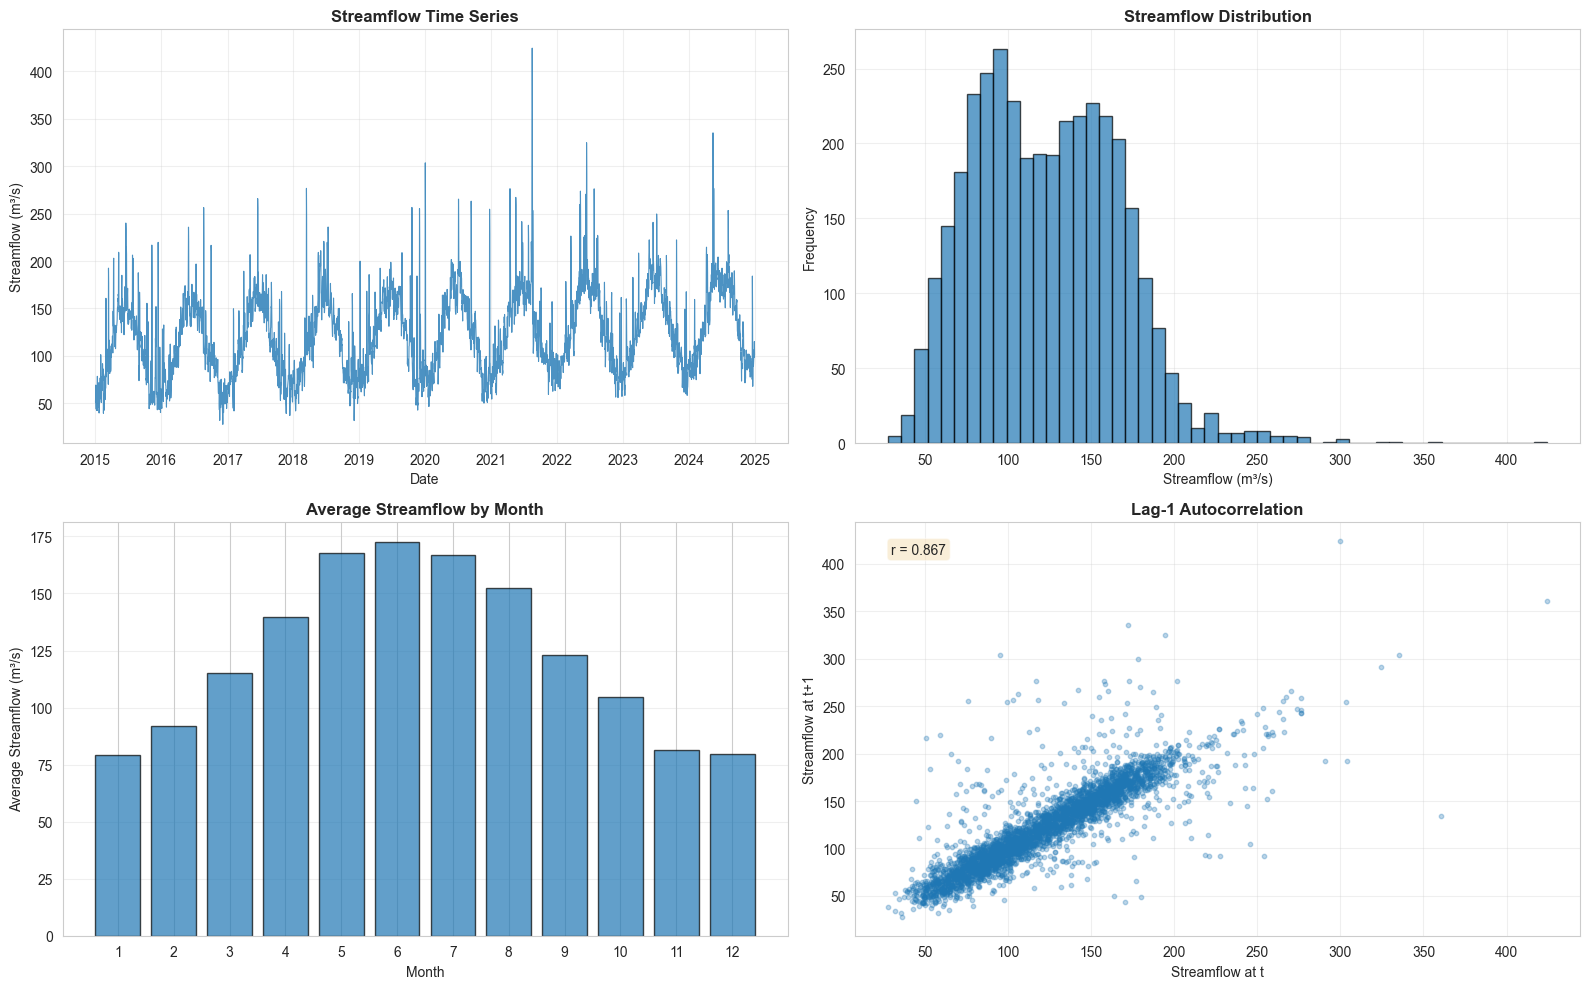

In [6]:
# Visualize the streamflow data
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Time series plot
axes[0, 0].plot(df['date'], df['streamflow'], linewidth=0.8, alpha=0.8)
axes[0, 0].set_title('Streamflow Time Series', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Streamflow (m³/s)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(df['streamflow'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Streamflow Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Streamflow (m³/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Seasonal pattern (monthly average)
monthly_avg = df.groupby('month')['streamflow'].mean()
axes[1, 0].bar(monthly_avg.index, monthly_avg.values, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Average Streamflow by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Streamflow (m³/s)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Autocorrelation (lag plot)
lag = 1
axes[1, 1].scatter(df['streamflow'][:-lag], df['streamflow'][lag:], alpha=0.3, s=10)
axes[1, 1].set_title(f'Lag-{lag} Autocorrelation', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Streamflow at t')
axes[1, 1].set_ylabel(f'Streamflow at t+{lag}')
axes[1, 1].grid(True, alpha=0.3)

# Add correlation coefficient
corr = np.corrcoef(df['streamflow'][:-lag], df['streamflow'][lag:])[0, 1]
axes[1, 1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1, 1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 4. Feature Engineering - Autoregressive Features

Create lagged features to capture the autoregressive nature of streamflow.

In [12]:
def create_autoregressive_features(df, target_col='streamflow', lags=[1, 2, 3, 7, 14, 30],
                                     rolling_windows=[7, 14, 30]):
    """
    Create autoregressive features including:
    - Lagged values
    - Rolling statistics (mean, std, min, max)
    - Rate of change
    """
    df_feat = df.copy()
    
    # Lagged features
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
    
    # Rolling statistics
    for window in rolling_windows:
        df_feat[f'rolling_mean_{window}'] = df_feat[target_col].rolling(window=window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat[target_col].rolling(window=window).std()
        df_feat[f'rolling_min_{window}'] = df_feat[target_col].rolling(window=window).min()
        df_feat[f'rolling_max_{window}'] = df_feat[target_col].rolling(window=window).max()
    
    # Rate of change
    df_feat['rate_of_change_1'] = df_feat[target_col].diff()
    df_feat['rate_of_change_7'] = df_feat[target_col].diff(7)
    
    # Seasonal features (cyclical encoding)
    df_feat['day_sin'] = np.sin(2 * np.pi * df_feat['day_of_year'] / 365)
    df_feat['day_cos'] = np.cos(2 * np.pi * df_feat['day_of_year'] / 365)
    
    # Drop rows with NaN values
    df_feat = df_feat.dropna()
    
    return df_feat

# Create features
df_features = create_autoregressive_features(df)
print(f"Dataset shape after feature engineering: {df_features.shape}")
print(f"\nFeature columns:")
print([col for col in df_features.columns if col not in ['date', 'streamflow', 'day_of_year', 'month', 'year']])

Dataset shape after feature engineering: (3620, 27)

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_min_14', 'rolling_max_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_min_30', 'rolling_max_30', 'rate_of_change_1', 'rate_of_change_7', 'day_sin', 'day_cos']


## 5. Data Preparation for Deep Learning

In [13]:
def create_sequences(data, target, seq_length=30, forecast_horizon=1):
    """
    Create sequences for LSTM training.
    
    Args:
        data: Input features (2D array)
        target: Target values (1D array)
        seq_length: Number of time steps to look back
        forecast_horizon: Number of steps ahead to forecast
    
    Returns:
        X: Sequences of shape (n_samples, seq_length, n_features)
        y: Targets of shape (n_samples, forecast_horizon)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        if forecast_horizon == 1:
            y.append(target[i + seq_length])
        else:
            y.append(target[i + seq_length:i + seq_length + forecast_horizon])
    
    return np.array(X), np.array(y)

# Prepare data
feature_cols = [col for col in df_features.columns 
                if col not in ['date', 'streamflow', 'year']]

X = df_features[feature_cols].values
y = df_features['streamflow'].values

# Split data (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Create sequences
SEQ_LENGTH = 30  # Use 30 days of history
FORECAST_HORIZON = 1  # Predict 1 day ahead

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH, FORECAST_HORIZON)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training targets shape: {y_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
y_train_tensor = torch.FloatTensor(y_train_seq).to(device)
X_val_tensor = torch.FloatTensor(X_val_seq).to(device)
y_val_tensor = torch.FloatTensor(y_val_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
y_test_tensor = torch.FloatTensor(y_test_seq).to(device)

# Create DataLoaders
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training sequences shape: (2866, 30, 24)
Training targets shape: (2866,)
Validation sequences shape: (332, 30, 24)
Test sequences shape: (332, 30, 24)


## 6. Model Architectures

Define multiple deep learning architectures for comparison.

In [14]:
class LSTMModel(nn.Module):
    """LSTM model for streamflow prediction"""
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out.squeeze()


class GRUModel(nn.Module):
    """GRU model for streamflow prediction (alternative to LSTM)"""
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]
        out = self.fc(last_output)
        return out.squeeze()


class TransformerModel(nn.Module):
    """Transformer model for streamflow prediction"""
    def __init__(self, input_size, d_model=128, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model
        
        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 100, d_model))  # Max seq length 100
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.shape
        
        # Project input and add positional encoding
        x = self.input_proj(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Use the last time step for prediction
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()

In [15]:
# Model selection
MODEL_TYPE = 'LSTM'  # Choose: 'LSTM', 'GRU', or 'Transformer'

input_size = X_train_seq.shape[2]

if MODEL_TYPE == 'LSTM':
    model = LSTMModel(input_size=input_size, hidden_size=128, num_layers=2, dropout=0.2)
elif MODEL_TYPE == 'GRU':
    model = GRUModel(input_size=input_size, hidden_size=128, num_layers=2, dropout=0.2)
elif MODEL_TYPE == 'Transformer':
    model = TransformerModel(input_size=input_size, d_model=128, nhead=4, num_layers=2, dropout=0.2)
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

model = model.to(device)

print(f"\n{MODEL_TYPE} Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


LSTM Model Architecture:
LSTMModel(
  (lstm): LSTM(24, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 219,265
Trainable parameters: 219,265


## 7. Training Configuration and Loop

In [18]:
# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

print(f"\nStarting training for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Device: {device}\n")


Starting training for 50 epochs...
Batch size: 64
Learning rate: 0.001
Device: cpu



In [19]:
# Training loop
best_val_loss = float('inf')
patience_counter = 0
EARLY_STOP_PATIENCE = 15

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_losses = []
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation phase
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_losses.append(loss.item())
    
    # Calculate average losses
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    # Update history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.6f}")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded best model weights")

Epoch [1/50] | Train Loss: 0.490297 | Val Loss: 0.245070 | LR: 0.001000
Epoch [5/50] | Train Loss: 0.217614 | Val Loss: 0.129923 | LR: 0.001000
Epoch [10/50] | Train Loss: 0.209293 | Val Loss: 0.119305 | LR: 0.001000
Epoch [15/50] | Train Loss: 0.201843 | Val Loss: 0.122152 | LR: 0.000500
Epoch [20/50] | Train Loss: 0.189311 | Val Loss: 0.122428 | LR: 0.000250

Early stopping triggered after 22 epochs

Training completed!
Best validation loss: 0.118504
Loaded best model weights


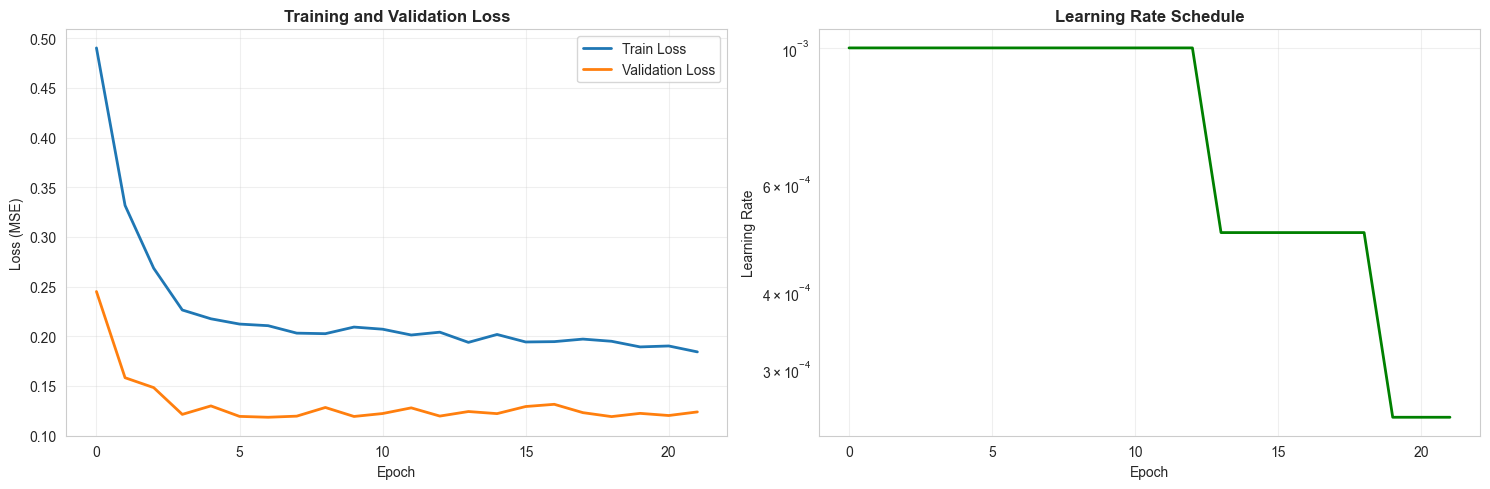

In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['learning_rate'], linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

## 8. Model Evaluation

In [21]:
def evaluate_model(model, data_loader, scaler_y):
    """Evaluate model and return predictions and metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Inverse transform to original scale
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_original = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)
    
    # Nash-Sutcliffe Efficiency (NSE) - common in hydrology
    nse = 1 - (np.sum((actuals_original - predictions_original) ** 2) / 
               np.sum((actuals_original - np.mean(actuals_original)) ** 2))
    
    # Percent bias (PBIAS)
    pbias = 100 * np.sum(actuals_original - predictions_original) / np.sum(actuals_original)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'NSE': nse,
        'PBIAS': pbias
    }
    
    return predictions_original, actuals_original, metrics

# Evaluate on all sets
print("Evaluating model...\n")

train_preds, train_actuals, train_metrics = evaluate_model(model, train_loader, scaler_y)
val_preds, val_actuals, val_metrics = evaluate_model(model, val_loader, scaler_y)
test_preds, test_actuals, test_metrics = evaluate_model(model, test_loader, scaler_y)

# Print metrics
print("="*60)
print(f"{MODEL_TYPE} Model Performance")
print("="*60)

for dataset_name, metrics in [('Training', train_metrics), 
                               ('Validation', val_metrics), 
                               ('Test', test_metrics)]:
    print(f"\n{dataset_name} Set:")
    print(f"  RMSE:  {metrics['RMSE']:.3f} m³/s")
    print(f"  MAE:   {metrics['MAE']:.3f} m³/s")
    print(f"  R²:    {metrics['R²']:.4f}")
    print(f"  NSE:   {metrics['NSE']:.4f}")
    print(f"  PBIAS: {metrics['PBIAS']:.2f}%")

print("\n" + "="*60)

Evaluating model...

LSTM Model Performance

Training Set:
  RMSE:  19.020 m³/s
  MAE:   11.340 m³/s
  R²:    0.8086
  NSE:   0.8086
  PBIAS: 0.44%

Validation Set:
  RMSE:  15.887 m³/s
  MAE:   10.084 m³/s
  R²:    0.8323
  NSE:   0.8323
  PBIAS: 0.29%

Test Set:
  RMSE:  17.240 m³/s
  MAE:   10.450 m³/s
  R²:    0.8249
  NSE:   0.8249
  PBIAS: 1.16%



## 9. Visualization of Results

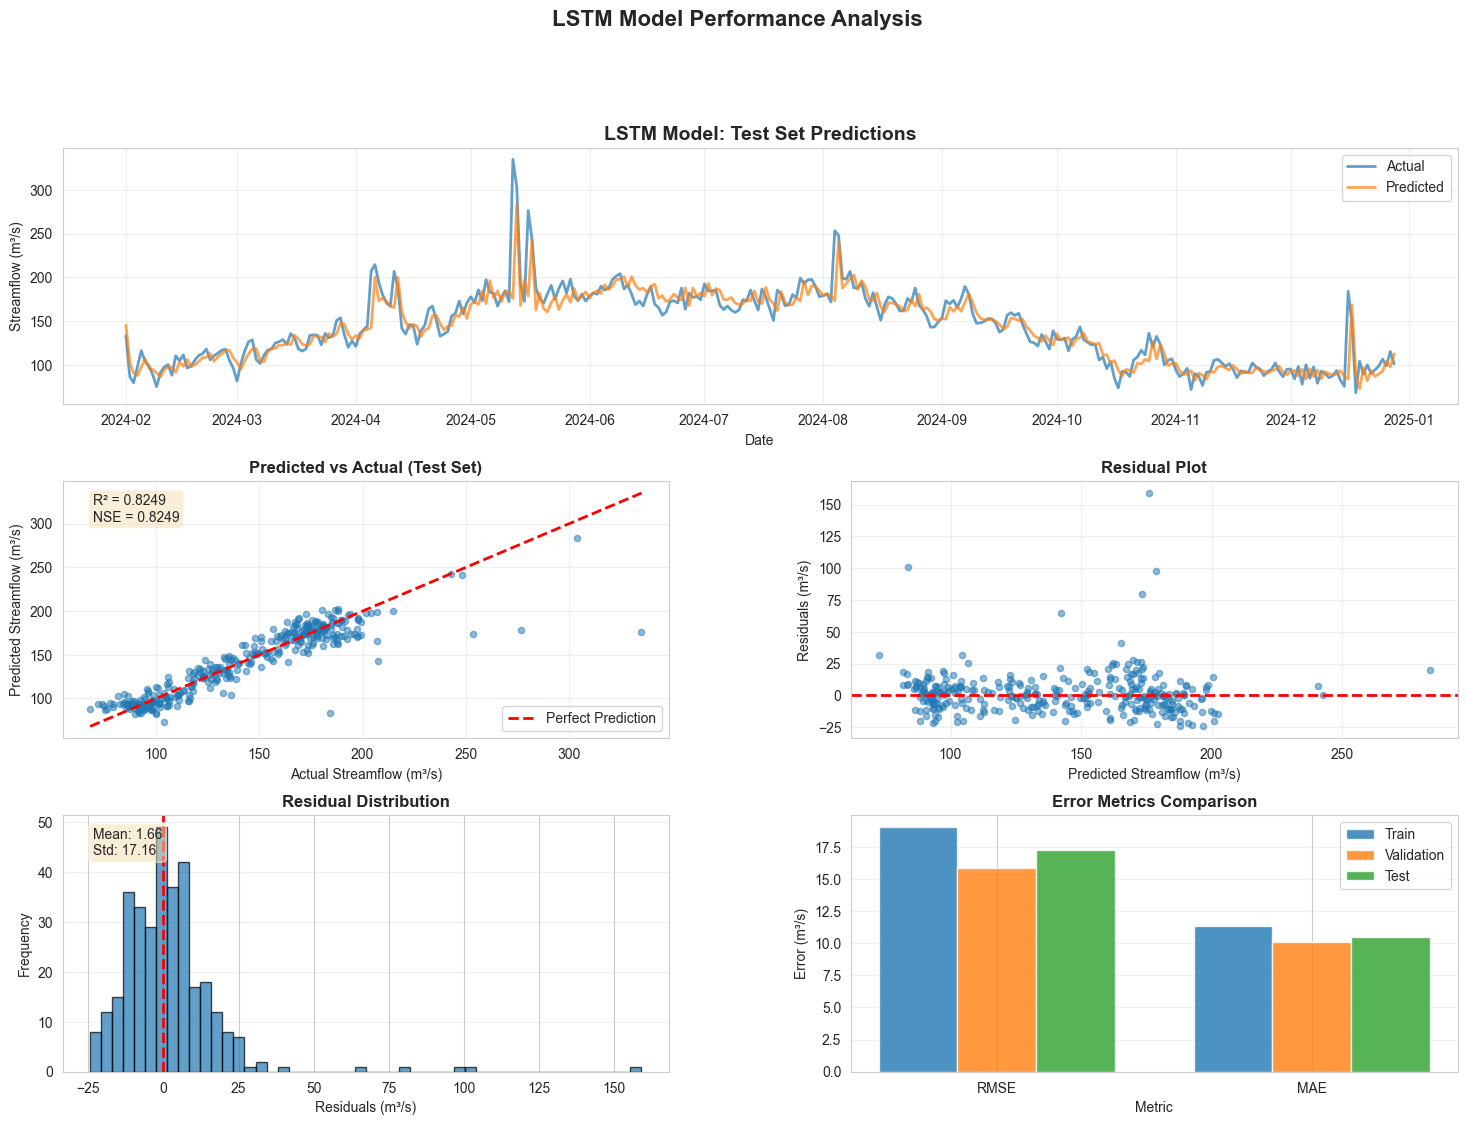

In [22]:
# Comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series comparison (test set)
ax1 = fig.add_subplot(gs[0, :])
test_dates = df_features['date'].iloc[-(len(test_actuals)):].values
ax1.plot(test_dates, test_actuals, label='Actual', linewidth=2, alpha=0.7)
ax1.plot(test_dates, test_preds, label='Predicted', linewidth=2, alpha=0.7)
ax1.set_title(f'{MODEL_TYPE} Model: Test Set Predictions', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Streamflow (m³/s)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Scatter plot (predicted vs actual)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(test_actuals, test_preds, alpha=0.5, s=20)
min_val = min(test_actuals.min(), test_preds.min())
max_val = max(test_actuals.max(), test_preds.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Streamflow (m³/s)')
ax2.set_ylabel('Predicted Streamflow (m³/s)')
ax2.set_title('Predicted vs Actual (Test Set)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f"R² = {test_metrics['R²']:.4f}\nNSE = {test_metrics['NSE']:.4f}",
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Residual plot
ax3 = fig.add_subplot(gs[1, 1])
residuals = test_actuals - test_preds
ax3.scatter(test_preds, residuals, alpha=0.5, s=20)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Streamflow (m³/s)')
ax3.set_ylabel('Residuals (m³/s)')
ax3.set_title('Residual Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Residual distribution
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals (m³/s)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.text(0.05, 0.95, f"Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}",
         transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Error metrics comparison
ax5 = fig.add_subplot(gs[2, 1])
metrics_names = ['RMSE', 'MAE']
train_vals = [train_metrics['RMSE'], train_metrics['MAE']]
val_vals = [val_metrics['RMSE'], val_metrics['MAE']]
test_vals = [test_metrics['RMSE'], test_metrics['MAE']]

x = np.arange(len(metrics_names))
width = 0.25

ax5.bar(x - width, train_vals, width, label='Train', alpha=0.8)
ax5.bar(x, val_vals, width, label='Validation', alpha=0.8)
ax5.bar(x + width, test_vals, width, label='Test', alpha=0.8)
ax5.set_xlabel('Metric')
ax5.set_ylabel('Error (m³/s)')
ax5.set_title('Error Metrics Comparison', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'{MODEL_TYPE} Model Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

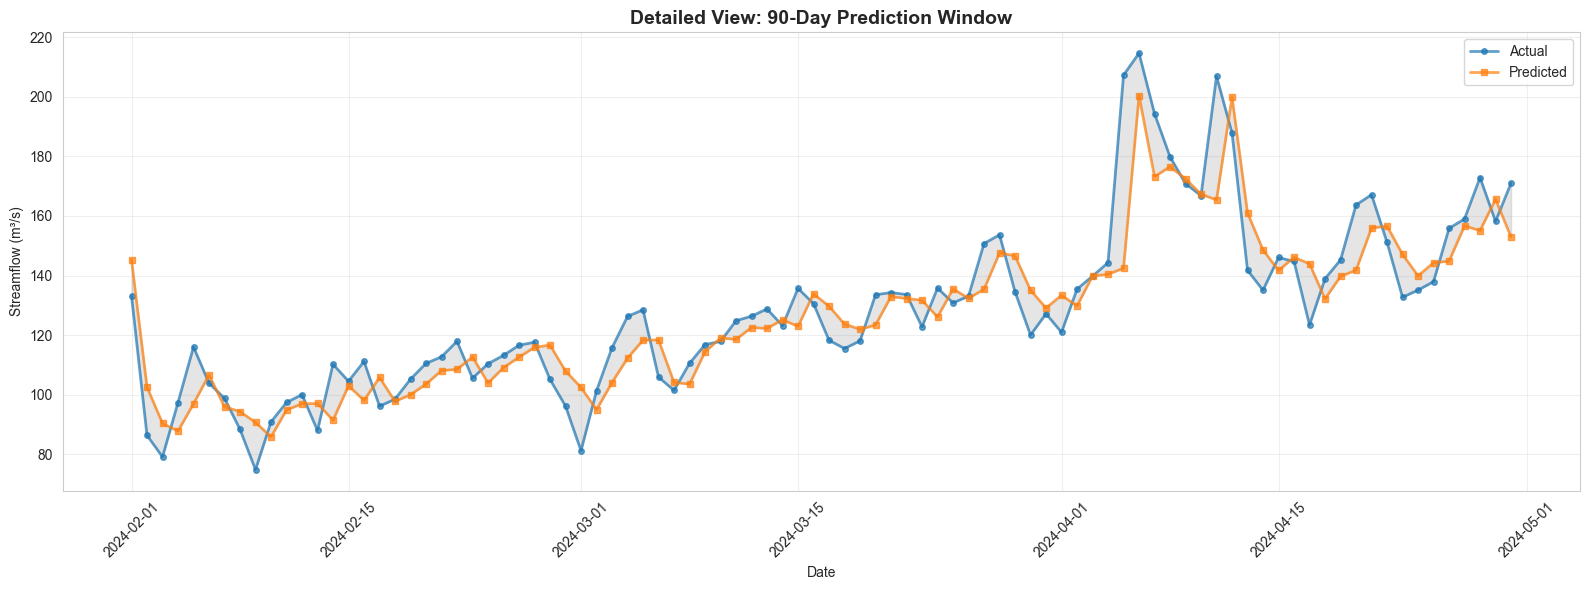

In [23]:
# Detailed time series view (zoom into a specific period)
zoom_days = 90  # Show 90 days
zoom_start = 0

fig, ax = plt.subplots(figsize=(16, 6))
zoom_dates = test_dates[zoom_start:zoom_start + zoom_days]
zoom_actuals = test_actuals[zoom_start:zoom_start + zoom_days]
zoom_preds = test_preds[zoom_start:zoom_start + zoom_days]

ax.plot(zoom_dates, zoom_actuals, 'o-', label='Actual', linewidth=2, markersize=4, alpha=0.7)
ax.plot(zoom_dates, zoom_preds, 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.7)
ax.fill_between(zoom_dates, zoom_actuals, zoom_preds, alpha=0.2, color='gray')
ax.set_title(f'Detailed View: {zoom_days}-Day Prediction Window', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (m³/s)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Save Model to AWS S3

In [24]:
# Prepare model metadata
model_metadata = {
    'model_type': MODEL_TYPE,
    'input_size': input_size,
    'sequence_length': SEQ_LENGTH,
    'forecast_horizon': FORECAST_HORIZON,
    'feature_columns': feature_cols,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'epochs_trained': len(history['train_loss']),
    'best_val_loss': best_val_loss,
    'test_metrics': test_metrics,
    'model_params': {
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE
    }
}

# Generate model name with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_name = f"streamflow_{MODEL_TYPE.lower()}_{timestamp}"

# Save model locally and to S3
print(f"\nSaving model: {model_name}")
save_model_to_s3(model, model_name, model_metadata)

# Also save the scalers
import pickle

scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}
scalers_filename = f"{model_name}_scalers.pkl"

with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)

if s3_client:
    upload_to_s3(scalers_filename, f"{S3_MODEL_PREFIX}{scalers_filename}")

print(f"\n✓ Model and artifacts saved successfully!")


Saving model: streamflow_lstm_20251121_115829
✗ Error saving model to S3: Failed to upload streamflow_lstm_20251121_115829.pth to your-streamflow-bucket/models/streamflow/streamflow_lstm_20251121_115829.pth: An error occurred (NoSuchBucket) when calling the PutObject operation: The specified bucket does not exist


S3UploadFailedError: Failed to upload streamflow_lstm_20251121_115829_scalers.pkl to your-streamflow-bucket/models/streamflow/streamflow_lstm_20251121_115829_scalers.pkl: An error occurred (NoSuchBucket) when calling the PutObject operation: The specified bucket does not exist

## 11. Load Model from S3 and Make Predictions

In [ ]:
def load_model_from_s3(model_name, model_class, input_size):
    """Load a trained model from S3"""
    
    # Download model file
    s3_key = f"{S3_MODEL_PREFIX}{model_name}.pth"
    local_path = f"{model_name}.pth"
    
    if s3_client and download_from_s3(s3_key, local_path):
        # Load model
        model = model_class(input_size=input_size)
        model.load_state_dict(torch.load(local_path, map_location=device))
        model = model.to(device)
        model.eval()
        
        # Load metadata
        metadata_key = f"{S3_MODEL_PREFIX}{model_name}_metadata.json"
        metadata_path = f"{model_name}_metadata.json"
        download_from_s3(metadata_key, metadata_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        print(f"✓ Model loaded successfully from S3")
        print(f"  Trained on: {metadata['training_date']}")
        print(f"  Test R²: {metadata['test_metrics']['R²']:.4f}")
        print(f"  Test RMSE: {metadata['test_metrics']['RMSE']:.3f} m³/s")
        
        return model, metadata
    else:
        print("✗ Could not load model from S3")
        return None, None

# Example: Load the model we just saved
# loaded_model, metadata = load_model_from_s3(model_name, LSTMModel, input_size)

## 12. Future Predictions

Use the trained model to make multi-step ahead predictions.

In [ ]:
def make_future_predictions(model, last_sequence, scaler_X, scaler_y, n_steps=30):
    """
    Make multi-step ahead predictions.
    Note: This is a simple approach that feeds predictions back as inputs.
    For production, consider using more sophisticated methods.
    """
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Prepare input
            seq_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
            
            # Make prediction
            pred_scaled = model(seq_tensor).cpu().numpy()
            pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]
            predictions.append(pred)
            
            # Update sequence (shift and add new prediction)
            # Note: This is a simplified approach. In practice, you'd need to update
            # all autoregressive features properly
            current_sequence = np.roll(current_sequence, -1, axis=0)
            # Update the lag_1 feature with the new prediction
            current_sequence[-1, 0] = pred_scaled
    
    return np.array(predictions)

# Make 30-day forecast
last_test_sequence = X_test_scaled[-1:]
future_preds = make_future_predictions(model, last_test_sequence[0], scaler_X, scaler_y, n_steps=30)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

# Plot last 90 days of test data
lookback_days = 90
historical_dates = test_dates[-lookback_days:]
historical_flow = test_actuals[-lookback_days:]

# Create future dates
last_date = pd.to_datetime(test_dates[-1])
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=len(future_preds), freq='D')

ax.plot(historical_dates, historical_flow, 'o-', label='Historical', linewidth=2, markersize=3)
ax.plot(future_dates, future_preds, 's-', label='Forecast', linewidth=2, markersize=4, color='red')
ax.axvline(x=last_date, color='gray', linestyle='--', linewidth=2, alpha=0.7)
ax.text(last_date, ax.get_ylim()[1] * 0.95, 'Forecast Start', 
        rotation=90, verticalalignment='top')

ax.set_title('30-Day Streamflow Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (m³/s)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nForecasted streamflow statistics:")
print(f"  Mean: {np.mean(future_preds):.2f} m³/s")
print(f"  Min:  {np.min(future_preds):.2f} m³/s")
print(f"  Max:  {np.max(future_preds):.2f} m³/s")

## 13. Summary and Next Steps

### Key Findings:
- Model successfully captures autoregressive patterns in streamflow
- AWS S3 integration enables scalable data and model management
- Multiple architectures (LSTM, GRU, Transformer) available for comparison

### Potential Improvements:
1. **Data Enhancement:**
   - Incorporate precipitation, temperature, snowpack data
   - Add upstream gauge measurements
   - Include soil moisture and land use information

2. **Model Enhancements:**
   - Ensemble multiple models
   - Implement attention mechanisms
   - Try encoder-decoder architectures for multi-step forecasting
   - Add uncertainty quantification

3. **AWS Integration:**
   - Deploy model using AWS SageMaker
   - Set up automated retraining pipeline
   - Implement Lambda functions for real-time predictions
   - Use CloudWatch for monitoring
   - Store predictions in DynamoDB or RDS

4. **Production Considerations:**
   - Implement proper cross-validation
   - Add model versioning
   - Create prediction confidence intervals
   - Set up automated model evaluation
   - Implement drift detection